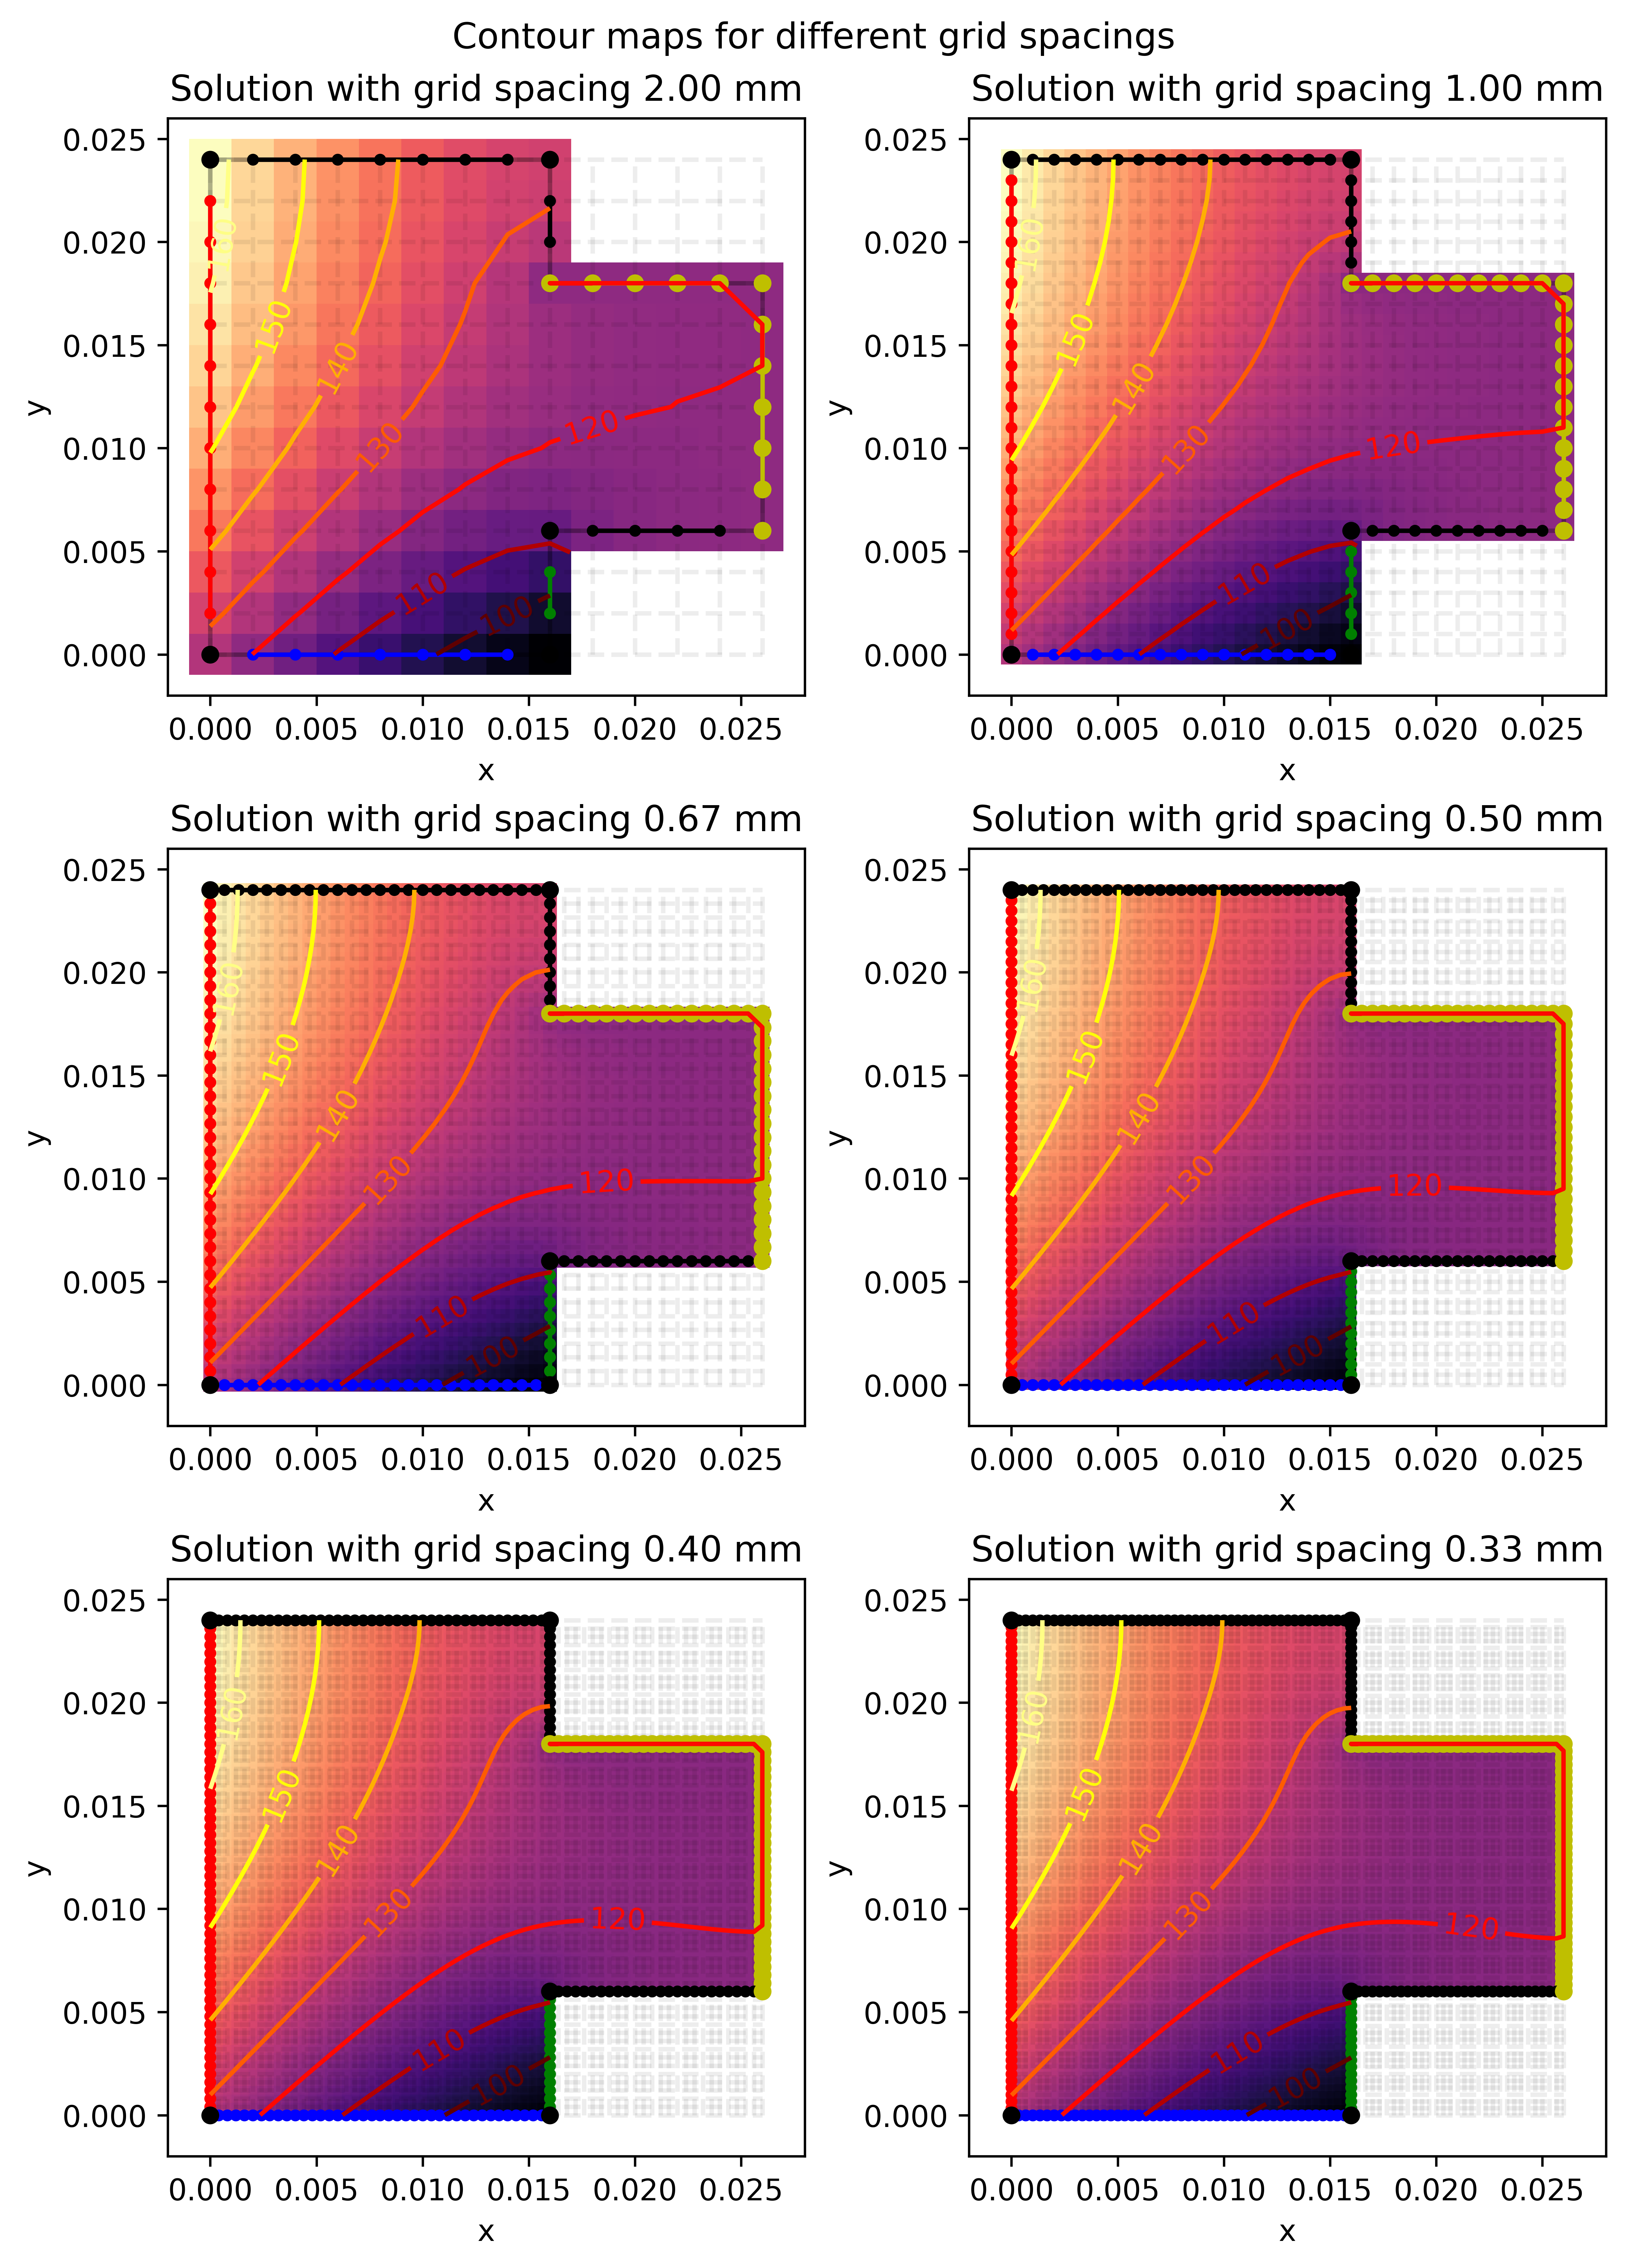

In [2]:
# Draw discretized domain
import matplotlib.pyplot as plt
import numpy as np
import scipy
import itertools


# Draw plot
fig, axs = plt.subplots(3, 2, constrained_layout=True, figsize=(7.5, 10.5),dpi=600);

def numerical_solution(n, ax):
    # Domain Parameters
    x_start, x_end, x_n = 0.0e-3, 26.0e-3, 13*n+1
    y_start, y_end, y_n = 0.0e-3, 24.0e-3, 12*n+1
    dx = (x_end - x_start)/(x_n-1)
    dy = (y_end - y_start)/(y_n-1)

    # Constants
    U_wall = 120 
    U_inf = 25
    C_hot = 50e3
    C_cold = -50e3
    k = 16
    h = 400

    # ####################################
    # # Initialize A matrix and Q vector # 
    # ####################################

    # Define coefficient matrix A (mostly laplacian) for LHS
    #Dxx = scipy.sparse.spdiags([np.ones(x_n), -2*np.ones(x_n), np.ones(x_n)], [-1, 0, 1], x_n, x_n) 
    #Dyy = scipy.sparse.spdiags([np.ones(y_n), -2*np.ones(y_n), np.ones(y_n)], [-1, 0, 1], y_n, y_n) 
    #L = scipy.sparse.kron(Dyy, np.eye(x_n)) + scipy.sparse.kron(np.eye(y_n), Dxx) 
    #A = L.tolil() # Convert from CSR (meant for fast computation) to Lil (meant for building up incrementally)

    # Defining matrix for LHS side of equations
    A = scipy.sparse.csr_matrix((x_n*y_n, x_n*y_n)).tolil()

    # Defining vector for RHS side of equations
    Q = scipy.sparse.csr_matrix((x_n*y_n, 1)).tolil()

    # ################################
    # # Initialize plotting commands #
    # ################################

    # Specify a rectangular grid
    X = np.linspace(x_start, x_end, num=x_n) # mesh points in x dir
    Y = np.linspace(y_start, y_end, num=y_n) # mesh points in y dir
    XX, YY = np.meshgrid(X, Y, indexing="ij")
    UU = np.zeros_like(XX)
    MASK = (XX > 16e-3) & ( (YY < 6e-3 - 1e-6)|(YY > 18e-3 + 1e-6))
    MASK = ~MASK

    # Plot the rectangular grid
    #ax.plot(XX[MASK],  YY[MASK],  marker='.', color='k', linestyle='none');
    #ax.plot(XX[~MASK], YY[~MASK], marker='.', color='w', linestyle='none');

    # Specify a rectangular grid
    ax.vlines(np.linspace(x_start, x_end, num=x_n), y_start, y_end, color='k', linestyle='dashed', alpha=0.07);
    ax.hlines(np.linspace(y_start, y_end, num=y_n), x_start, x_end, color='k', linestyle='dashed', alpha=0.07);

    # Boundary Conditions Lines
    ax.plot([ 0e-3,  0e-3], [24e-3,  0e-3], color='k', linestyle='solid', alpha=0.3);  # B1 Hot Flux
    ax.plot([ 0e-3, 16e-3], [ 0e-3,  0e-3], color='k', linestyle='solid', alpha=0.3);  # B2 Cold flux
    ax.plot([16e-3, 16e-3], [ 0e-3,  6e-3], color='k', linestyle='solid', alpha=0.3);  # B3 Convection
    ax.plot([16e-3, 26e-3], [ 6e-3,  6e-3], color='k', linestyle='solid', alpha=0.3);  # B4 Adiabatic
    ax.plot([26e-3, 26e-3], [ 6e-3, 18e-3], color='k', linestyle='solid', alpha=0.3);  # B5 Constant Temperature
    ax.plot([26e-3, 16e-3], [18e-3, 18e-3], color='k', linestyle='solid', alpha=0.3);  # B6 Constant Temperature
    ax.plot([16e-3, 16e-3], [18e-3, 24e-3], color='k', linestyle='solid', alpha=0.3);  # B7 Adiabatic
    ax.plot([16e-3,  0e-3], [24e-3, 24e-3], color='k', linestyle='solid', alpha=0.3);  # B8 Symmetric

    # Add FD stencils to B1 - Hot Heat Flux
    # #####################################
    B1 =  [(1,j)      for j in range(int(2), int(24e-3/dx)+1)]
    B1x = [(i-1) * dx for (i,j) in B1 ]
    B1y = [(j-1) * dy for (i,j) in B1 ]
    ax.plot(B1x, B1y,  marker='.', color='r',label='B1')

    for (i,j) in B1:
        l = (i-1)*y_n + j - 1
        A[l,:] = 0        # Clear the row
        #A[l, l-y_n] = 0  #U[i-1, j  ]
        A[l, l-1   ] = 1  #U[i,   j-1]
        A[l, l     ] = -4 #U[i,   j  ]
        A[l, l+1   ] = 1  #U[i,   j+1]
        A[l, l+y_n ] = 2  #U[i+1, j  ]
        Q[l] = -(2*C_hot*dx)/k        

    # Add FD stencils to B3 - Convection
    # ##################################
    B3 =  [(int(16e-3/dx)+1,j)      for j in range(int(2), int(6e-3/dx)+1)]
    B3x = [(i-1) * dx for (i,j) in B3 ]
    B3y = [(j-1) * dy  for (i,j) in B3 ]
    ax.plot(B3x, B3y,  marker='.', color='g', label='B3')

    for (i,j) in B3:
        l = (i-1)*y_n + j - 1
        A[l,:] = 0       # Clear the row
        A[l, l] = -(4 + 2*dx*h/k)     #U[i,   j  ]
        #A[l, l+y_n] = 0  #U[i-1, j  ]
        A[l, l-y_n] = 2  #U[i-1, j  ]
        A[l, l-1] = 1    #U[i,   j-1]
        A[l, l+1] = 1    #U[i,   j+1]    

        Q[l] = -2*dx*h*U_inf/k      

    # Add FD stencils to B5 - Constant Temperature
    # ############################################
    B5 =  [(int(26e-3/dx)+1,j)      for j in range(int(6e-3/dx)+2, int(18e-3/dx)+1)]
    B5x = [(i-1) * dx for (i,j) in B5 ]
    B5y = [(j-1) * dy  for (i,j) in B5 ]
    ax.plot(B5x, B5y,  marker='.', color='y',label='B5',markersize=10)

    for (i,j) in B5:    
        l = (i-1)*y_n + j - 1
        A[l,:] = 0      # Clear the row
        A[l, l] = 1     #U[i,   j  ]
        Q[l] = U_wall               


    # Add FD stencils to B7 - Adiabatic
    # #################################
    B7 =  [(int(16e-3/dx)+1,j)      for j in range(int(18e-3/dx)+2, int(24e-3/dx)+1)]
    B7x = [(i-1) * dx for (i,j) in B7 ]
    B7y = [(j-1) * dy  for (i,j) in B7 ]
    ax.plot(B7x, B7y,  marker='.', color='k',label='B7')

    for (i,j) in B7:
        l = (i-1)*y_n + j - 1
        A[l,:] = 0       # Clear the row
        A[l, l-y_n] = 0.5  #U[i-1, j  ]
        A[l, l-1  ] = 0.25   #U[i,   j-1]
        A[l, l    ] = -1    #U[i,   j  ]
        A[l, l+1  ] = 0.25   #U[i,   j+1]
        #A[l, l+y_n] = 0.25  #U[i+1, j  ]
        Q[l] = 0    



    # Add FD stencils to B2 - Cold Heat Flux
    # ######################################
    B2 =  [(i,1)      for i in range(int(2), int(16e-3/dx)+1)]
    B2x = [(i-1) * dx for (i,j) in B2 ]
    B2y = [(j-1) * dy  for (i,j) in B2 ]
    ax.plot(B2x, B2y,  marker='.', color='b', label='B2')

    for (i,j) in B2:
        l = (i-1)*y_n + j - 1
        A[l,:] = 0       # Clear the row
        A[l, l-y_n] = 1  #U[i-1, j  ]
        #A[l, l-1] = 0    #U[i,   j-1]
        A[l, l] = -4     #U[i,   j  ]
        A[l, l+1] = 2    #U[i,   j+1]
        A[l, l+y_n] = 1  #U[i+1, j  ]
        Q[l] = (-2*C_cold*dx)/k       

    # Add FD stencils to B4 - Adiabatic
    # #################################
    B4 =  [(i,int(6e-3/dx)+1)      for i in range(int(16e-3/dx)+2, int(26e-3/dx)+1)]
    B4x = [(i-1) * dx for (i,j) in B4 ]
    B4y = [(j-1) * dy  for (i,j) in B4 ]
    ax.plot(B4x, B4y,  marker='.', color='k',label='B4')

    for (i,j) in B4:
        l = (i-1)*y_n + j - 1
        A[l,:] = 0       # Clear the row
        A[l, l-y_n] = 0.25  # U[i-1, j  ]
        #A[l, l-1] = 0   # U[i,   j-1]
        A[l, l    ] = -1     # U[i,   j  ]
        A[l, l+1  ] = 0.50    # U[i,   j+1]
        A[l, l+y_n] = 0.25  # U[i+1, j  ]
        Q[l] = 0

    # Add FD stencils to B6 - Constant Temperature
    # ############################################
    B6 =  [(i,int(18e-3/dx)+1)      for i in range(int(16e-3/dx)+2, int(26e-3/dx)+1)]
    B6x = [(i-1) * dx for (i,j) in B6 ]
    B6y = [(j-1) * dy for (i,j) in B6 ]
    ax.plot(B6x, B6y,  marker='.', color='y',label='B6',markersize=10)

    for (i,j) in B6:    
        l = (i-1)*y_n + j - 1
        A[l,:] = 0      # Clear the row
        A[l, l] = 1     #U[i,   j  ]
        Q[l] = U_wall       


    # Add FD stencils to B8 - Symmetric
    # #################################
    B8 =  [(i,int(24e-3/dx)+1)      for i in range(int(1+1), int(16e-3/dx)+1)]
    B8x = [(i-1) * dx for (i,j) in B8 ]
    B8y = [(j-1) * dy  for (i,j) in B8 ]
    ax.plot(B8x, B8y,  marker='.', color='k',label='B8')

    for (i,j) in B8:
        l = (i-1)*y_n + j - 1
        A[l,:] = 0         # Clear the row
        A[l, l-y_n] = 0.25  # U[i-1, j  ]
        A[l, l-1  ] = 0.50  # U[i,   j-1]
        A[l, l    ] = -1   # U[i,   j  ]
        #A[l, l-1  ] = 0  # U[i,   j+1]    
        A[l, l+y_n] = 0.25  # U[i+1, j  ]
        Q[l] = 0        

    # Add FD stencils to B12
    # ######################
    B12 =  [(1,1)]
    B12x = [(i-1) * dx for (i,j) in B12 ]
    B12y = [(j-1) * dy for (i,j) in B12 ]
    ax.plot(B12x, B12y,  marker='.', color='k', markersize=10)    

    for (i,j) in B12:
        l = (i-1)*y_n + j - 1
        A[l,:] = 0       # Clear the row
        #A[l, l-y_n] = 1  #U[i-1, j  ]
        #A[l, l-1] = 0    #U[i,   j-1]
        A[l, l] = -2     #U[i,   j  ]
        A[l, l+1] = 1    #U[i,   j+1]
        A[l, l+y_n] = 1  #U[i+1, j  ]
        Q[l] = -(C_hot*dx)/k -(C_cold*dx)/k       

    # Add FD stencils to B23   
    # ######################    
    B23 =  [(int(16e-3/dx)+1,1)]
    B23x = [(i-1) * dx  for (i,j) in B23 ]
    B23y = [(j-1) * dy  for (i,j) in B23]
    ax.plot(B23x, B23y,  marker='.', color='k', markersize=10)    

    for (i,j) in B23:
        l = (i-1)*y_n + j - 1
        A[l,:] = 0       # Clear the row
        A[l, l-y_n] = 1  #U[i-1, j  ]
        #A[l, l-1 ] = 2    #U[i,   j-1]
        A[l, l    ] = -(2 + dx*h/k)    #U[i,   j  ]
        A[l, l+1  ] = 1    #U[i,   j+1]
        #A[l, l+y_n] = 2  #U[i+1, j  ]
        Q[l] = -(dx*h*U_inf/k)  -(C_cold*dx/k)  



    # Add FD stencils to B34
    # ######################
    B34 =  [(int(16e-3/dx)+1,int(6e-3/dx)+1)]
    B34x = [(i-1) * dx  for (i,j) in B34]
    B34y = [(j-1) * dy  for (i,j) in B34]
    ax.plot(B34x, B34y,  marker='.', color='k', markersize=10)    

    for (i,j) in B34:
        l = (i-1)*y_n + j - 1
        A[l,:] = 0       # Clear the row
        A[l, l-y_n] = 2  #U[i-1, j  ]
        A[l, l-1  ] = 1    #U[i,   j-1]
        A[l, l    ] = -(6 + dx*h/k)    #U[i,   j  ]
        A[l, l+1  ] = 2    #U[i,   j+1]
        A[l, l+y_n] = 1  #U[i+1, j  ]
        Q[l] = -(dx*h*U_inf/k)     



    # Add FD stencils to B45 - Constant Temperature
    # #############################################    
    B45 =  [(int(26e-3/dx)+1,int(6e-3/dx)+1)]
    B45x = [(i-1) * dx  for (i,j) in B45]
    B45y = [(j-1) * dy  for (i,j) in B45]
    ax.plot(B45x, B45y,  marker='.', color='y',markersize=10)

    for (i,j) in B45:    
        l = (i-1)*y_n + j - 1
        A[l,:] = 0      # Clear the row
        A[l, l] = 1     #U[i,   j  ]
        Q[l] = U_wall  



    # Add FD stencils to B56 - Constant Temperature
    # #############################################
    B56 =  [(int(26e-3/dx)+1,int(18e-3/dx)+1)]
    B56x = [(i-1) * dx  for (i,j) in B56]
    B56y = [(j-1) * dy  for (i,j) in B56]
    ax.plot(B56x, B56y,  marker='.', color='y',markersize=10)

    for (i,j) in B56:    
        l = (i-1)*y_n + j - 1
        A[l,:] = 0      # Clear the row
        A[l, l] = 1     #U[i,   j  ]
        Q[l] = U_wall      



    # Add FD stencils to B67 - Constant Temperature
    # ####################################3########
    B67 =  [(int(16e-3/dx)+1,int(18e-3/dx)+1)]
    B67x = [(i-1) * dx  for (i,j) in B67]
    B67y = [(j-1) * dy  for (i,j) in B67]
    ax.plot(B67x, B67y,  marker='.', color='y',markersize=10)

    for (i,j) in B67:    
        l = (i-1)*y_n + j - 1
        A[l,:] = 0      # Clear the row
        A[l, l] = 1     #U[i,   j  ]
        Q[l] = U_wall      




    # Add FD stencils to B78 - Adiabatic
    # ####################################3########
    B78 =  [(int(16e-3/dx)+1,int(24e-3/dx)+1)]
    B78x = [(i-1) * dx  for (i,j) in B78]
    B78y = [(j-1) * dy  for (i,j) in B78]
    ax.plot(B78x, B78y,  marker='.', color='k',markersize=10)    
    for (i,j) in B78:    
        l = (i-1)*y_n + j - 1
        A[l,:] = 0       # Clear the row
        A[l, l-y_n] = 0.5  #U[i-1, j  ]
        A[l, l-1] = 0.5    #U[i,   j-1]
        A[l, l] = -1     #U[i,   j  ]
        Q[l] = 0    



    # Add FD stencils to B81
    # ######################
    B81 =  [(1,int(24e-3/dx)+1)]
    B81x = [(i-1) * dx  for (i,j) in B81]
    B81y = [(j-1) * dy  for (i,j) in B81]
    ax.plot(B81x, B81y,  marker='.', color='k',markersize=10)  

    for (i,j) in B81:
        l = (i-1)*y_n + j - 1
        A[l,:] = 0       # Clear the row
        #A[l, l-y_n] = 1  #U[i-1, j  ]
        A[l, l-1] = 1    #U[i,   j-1]
        A[l, l] = -2     #U[i,   j  ]
        #A[l, l+1] = 1    #U[i,   j+1]
        A[l, l+y_n] = 1  #U[i+1, j  ]
        Q[l] = -(C_hot*dx)/k    

    # Add FD stencils to null nodes in upper node
    # ###########################################
    B_null_upper = [(i,j) for (i,j) in itertools.product(
        list(range(int(16e-3/dx)+2, int(26e-3/dx+2))), 
        list(range(int(18e-3/dx)+1+1, int(24e-3/dx)+2)))] 

    for (i,j) in B_null_upper:
        l = (i-1)*y_n + j - 1
        A[l,:] = 0       # Clear the row
        #A[l, l-y_n] = 0  #U[i-1, j  ]
        #A[l, l-1] = 0    #U[i,   j-1]
        A[l, l] = 1     #U[i,   j  ]
        #A[l, l+1] = 0    #U[i,   j+1]
        #A[l, l+y_n] = 0  #U[i+1, j  ]
        Q[l] = 0  

    B_null_upperx = [(i-1) * dx  for (i,j) in B_null_upper]
    B_null_uppery = [(j-1) * dy  for (i,j) in B_null_upper]    
    #ax.plot(B_null_upperx, B_null_uppery,  
    #        marker='.', 
    #        color='w',
    #        markersize=10,
    #        linestyle='none',
    #        label='B_{null}')

    # Add FD stencils to null nodes in lower node
    # ###########################################
    B_null_lower = [(i,j) for (i,j) in itertools.product(
        range(int(16e-3/dx)+2, int(26e-3/dx+2)), 
        range(1, int(6e-3/dx)+1))]

    for (i,j) in B_null_lower:
        l = (i-1)*y_n + j - 1
        A[l,:] = 0       # Clear the row
        #A[l, l-y_n] = 0  #U[i-1, j  ]
        #A[l, l-1] = 0    #U[i,   j-1]
        A[l, l] = 1     #U[i,   j  ]
        #A[l, l+1] = 0    #U[i,   j+1]
        #A[l, l+y_n] = 0  #U[i+1, j  ]
        Q[l] = 0  

    B_null_lowerx = [(i-1) * dx  for (i,j) in B_null_lower]
    B_null_lowery = [(j-1) * dy  for (i,j) in B_null_lower]    
    #ax.plot(B_null_lowerx, B_null_lowery,  
    #        marker='.', 
    #        color='w',
    #        markersize=10,
    #        linestyle='none',
    #        label='B_{null}')


    # Add FD Stencils to literally everything else
    # ############################################
    B_not_interior = B_null_lower + B_null_upper 
    B_not_interior = B_not_interior + B1 + B2 + B3 + B4
    B_not_interior = B_not_interior + B5 + B6 + B7 + B8
    B_not_interior = B_not_interior + B12 + B23 + B34 + B45
    B_not_interior = B_not_interior + B56 + B67 + B78 + B81

    B_interior = [(i,j) for (i,j) in itertools.product(
        list(range(1, int(26e-3/dx+2))), 
        list(range(1, int(24e-3/dx)+2)))] 
    B_interior = [ij for ij in B_interior if ij not in B_not_interior]
    for (i,j) in B_interior:
        l = (i-1)*y_n + j - 1
        A[l,:] = 0       # Clear the row
        A[l, l-y_n] = 0.25  #U[i-1, j  ]
        A[l, l-1  ] = 0.25    #U[i,   j-1]
        A[l, l    ] = -1     #U[i,   j  ]
        A[l, l+1  ] = 0.25    #U[i,   j+1]
        A[l, l+y_n] = 0.25  #U[i+1, j  ]
        Q[l] = 0  

    B_interiorx = [(i-1) * dx  for (i,j) in B_interior]
    B_interiory = [(j-1) * dy  for (i,j) in B_interior]  
    #ax.plot(B_interiorx,  B_interiory,  marker='.', color='k', linestyle='none');

    # Plot labels

    ax.set_xlabel('x') 
    ax.set_ylabel('y') 
    ax.set_xlim(-2e-3, 28e-3)
    ax.set_ylim(-2e-3, 26e-3)
    #ax.legend()

    Ainv = np.linalg.inv(A.toarray())
    #Ainv = scipy.sparse.linalg.inv(A)
    ans = Ainv.dot(Q.toarray())
    UU = np.reshape(np.ravel(ans), (x_n,y_n))
    UU = np.ma.array(UU, mask = ~MASK)

    #return XX,YY,UU,MASK

    ax.pcolormesh(XX, YY, UU,cmap='magma', vmax=np.max(UU[MASK]))#, vmax=np.min(UU[MASK]))

    CS = ax.contour(XX,YY,UU,cmap='hot')                             
    ax.clabel(CS, inline=True, fontsize=10)
    #plt.show()
    #fig.savefig('solution_contour_04mm.png')

    
numerical_solution(1, axs[0][0])   
numerical_solution(2, axs[0][1])   
numerical_solution(3, axs[1][0])   
numerical_solution(4, axs[1][1])
numerical_solution(5, axs[2][0])   
numerical_solution(6, axs[2][1])

axs[0][0].set_title("Solution with grid spacing 2.00 mm")
axs[0][1].set_title("Solution with grid spacing 1.00 mm")
axs[1][0].set_title("Solution with grid spacing 0.67 mm")
axs[1][1].set_title("Solution with grid spacing 0.50 mm")
axs[2][0].set_title("Solution with grid spacing 0.40 mm")
axs[2][1].set_title("Solution with grid spacing 0.33 mm")
fig.suptitle("Contour maps for different grid spacings")
plt.show()

fig.savefig('solution_contour.png')